# 페이지 구성

#### 모듈
#### 지연 최적치 test
#### 최적모델 test
#### 최적모델 저장

In [14]:
import pandas as pd
from pycaret.classification import setup, compare_models, create_model, tune_model, evaluate_model, save_model, load_model
from pycaret.regression import *
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [2]:
# 가격 지연 최적치 함수
def lags(Market, Item, Buoy):
    # 데이터 로드 및 전처리
    price_data = pd.read_csv('../../data/prep/item_price_filled_pivot.csv', encoding='utf-8-sig')
    price_data['날짜'] = pd.to_datetime(price_data['priceDate']).dt.date

    # 특정 시장과 품목의 가격 필터링
    data_noryang = price_data[price_data['market'] == Market]
    data_noryang = data_noryang.filter(items=['날짜', f'{Item}_avgPrice'])

    daily_avg_price = data_noryang.groupby('날짜').mean().reset_index()
    daily_avg_price.rename(columns={f'{Item}_avgPrice': 'avgPrice'}, inplace=True)

    # 기상 데이터 불러오기 및 부이 필터링
    forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
    forecast_df['날짜'] = pd.to_datetime(forecast_df['일시']).dt.date
    buoy_filtered = forecast_df[forecast_df['지점'] == Buoy].drop(columns=['일시'])
    daily_avg_weather = buoy_filtered.groupby('날짜').mean(numeric_only=True).reset_index()
    # 최적 지연 기간 찾기 함수
    def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=600, bootstrap_samples=50):
        results = {}

        for feature in feature_list:
            best_corr = -1
            best_lag = 0
            bootstrap_lags = []

            for lag in range(1, max_lag + 1):
                shifted_prices = fish_prices.copy()
                shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)
                weather_data.dropna(inplace=True)
                shifted_prices.dropna(inplace=True)
                merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
                if merged_df.empty:
                    continue

                # 상관관계 분석
                scaler = StandardScaler()
                weather_scaled = scaler.fit_transform(merged_df[[feature]])
                price_scaled = scaler.fit_transform(merged_df[['avgPrice']])

                corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                if corr > best_corr:
                    best_corr = corr
                    best_lag = lag

            # 부트스트래핑을 통한 신뢰 구간 계산
            for _ in range(bootstrap_samples):
                sampled_indices = np.random.choice(len(merged_df), len(merged_df), replace=True)
                sampled_merged = merged_df.iloc[sampled_indices]

                if not sampled_merged.empty:
                    weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                    price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                    boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                    bootstrap_lags.append(boot_corr)

            conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

            results[feature] = {
                '최적 지연 기간': best_lag,
                '상관계수': best_corr,
                '신뢰구간': (conf_low, conf_high)
            }

        return results

    # 분석 수행
    feature_columns = daily_avg_weather.columns.drop('날짜')
    optimal_lags_with_confidence = find_optimal_lags_with_confidence(daily_avg_price, daily_avg_weather, feature_columns)

    # 결과 출력
    print(f"\n가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목={Item}/ 시장={Market}/ 부이={Buoy}):")
    for feature, result in optimal_lags_with_confidence.items():
        print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}, 범위: {result['신뢰구간'][1] - result['신뢰구간'][0]:.4f}")

    # 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
                y=list(optimal_lags_with_confidence.keys()),
                palette='viridis')
    plt.title(f'{Market} {Item} 가격에 대한 기상 요인의 최적 지연 기간 (부이={Buoy})')
    plt.xlabel('최적 지연 기간 (일)')
    plt.ylabel('기상 요인')
    plt.grid()
    plt.show()


가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목=대게/ 시장=가락시장/ 부이=22107):
지점: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
풍속: 371일, 상관계수: 0.3066, 신뢰구간: -0.1290 ~ -0.0577, 범위: 0.0713
GUST풍속: 371일, 상관계수: 0.3199, 신뢰구간: -0.1349 ~ -0.0697, 범위: 0.0652
현지기압: 355일, 상관계수: 0.4616, 신뢰구간: -0.2769 ~ -0.2032, 범위: 0.0737
습도: 219일, 상관계수: 0.3258, 신뢰구간: 0.2048 ~ 0.2603, 범위: 0.0556
기온: 526일, 상관계수: 0.4746, 신뢰구간: 0.0126 ~ 0.0574, 범위: 0.0448
수온: 151일, 상관계수: 0.5797, 신뢰구간: -0.0542 ~ -0.0048, 범위: 0.0494
최대파고: 21일, 상관계수: 0.2331, 신뢰구간: -0.1327 ~ -0.0634, 범위: 0.0693
유의파고: 24일, 상관계수: 0.2253, 신뢰구간: -0.1207 ~ -0.0568, 범위: 0.0639
평균파고: 24일, 상관계수: 0.2558, 신뢰구간: -0.0699 ~ -0.0140, 범위: 0.0559
파주기: 175일, 상관계수: 0.1605, 신뢰구간: -0.0783 ~ -0.0185, 범위: 0.0598


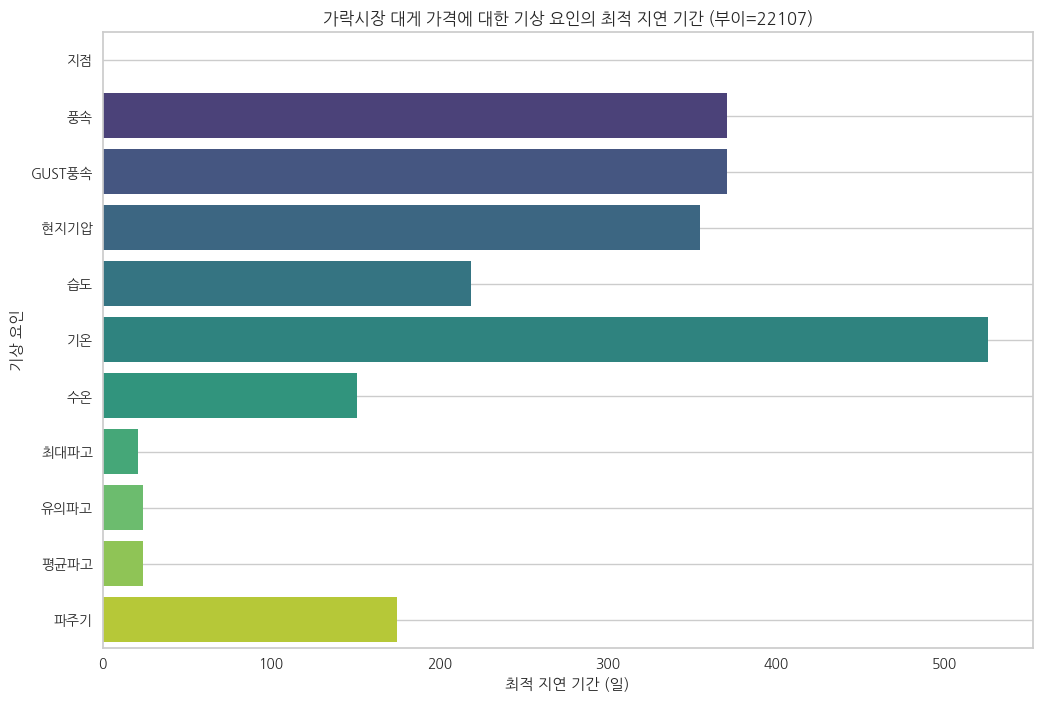


가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목=대게/ 시장=가락시장/ 부이=22302):
지점: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
풍속: 390일, 상관계수: 0.2417, 신뢰구간: -0.1533 ~ -0.0232, 범위: 0.1300
GUST풍속: 390일, 상관계수: 0.3345, 신뢰구간: -0.1959 ~ -0.0689, 범위: 0.1270
현지기압: 355일, 상관계수: 0.6262, 신뢰구간: -0.4682 ~ -0.3298, 범위: 0.1383
습도: 554일, 상관계수: 0.6499, 신뢰구간: 0.3065 ~ 0.4492, 범위: 0.1427
기온: 520일, 상관계수: 0.7677, 신뢰구간: 0.0909 ~ 0.1833, 범위: 0.0924
수온: 508일, 상관계수: 0.7446, 신뢰구간: -0.1701 ~ -0.0524, 범위: 0.1176
최대파고: 388일, 상관계수: 0.3800, 신뢰구간: -0.2854 ~ -0.0990, 범위: 0.1864
유의파고: 388일, 상관계수: 0.4040, 신뢰구간: -0.2498 ~ -0.1123, 범위: 0.1375
평균파고: 388일, 상관계수: 0.4044, 신뢰구간: -0.2297 ~ -0.1127, 범위: 0.1169
파주기: 18일, 상관계수: 0.3370, 신뢰구간: -0.1974 ~ -0.1036, 범위: 0.0938


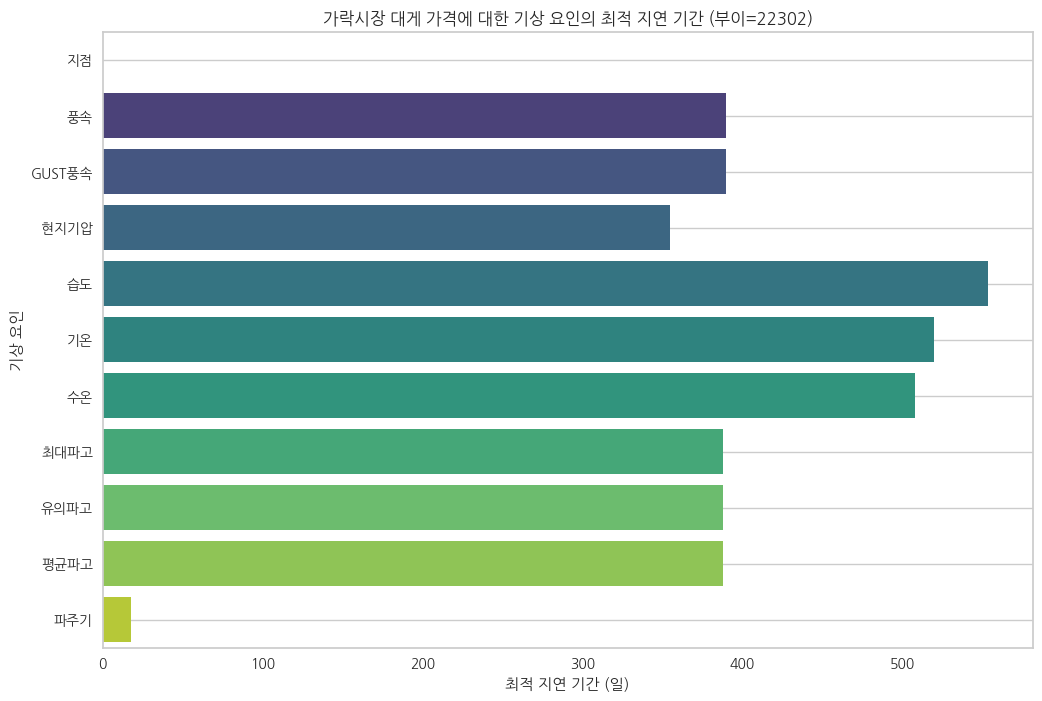


가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목=대게/ 시장=노량진 1층/ 부이=22107):
지점: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
풍속: 370일, 상관계수: 0.2905, 신뢰구간: -0.1066 ~ -0.0369, 범위: 0.0697
GUST풍속: 16일, 상관계수: 0.3032, 신뢰구간: -0.1137 ~ -0.0610, 범위: 0.0526
현지기압: 346일, 상관계수: 0.4579, 신뢰구간: -0.1956 ~ -0.1463, 범위: 0.0493
습도: 196일, 상관계수: 0.3347, 신뢰구간: 0.1700 ~ 0.2224, 범위: 0.0524
기온: 517일, 상관계수: 0.4712, 신뢰구간: -0.0629 ~ -0.0057, 범위: 0.0571
수온: 143일, 상관계수: 0.5614, 신뢰구간: -0.1246 ~ -0.0762, 범위: 0.0485
최대파고: 18일, 상관계수: 0.2313, 신뢰구간: -0.1172 ~ -0.0517, 범위: 0.0655
유의파고: 18일, 상관계수: 0.2288, 신뢰구간: -0.1023 ~ -0.0373, 범위: 0.0649
평균파고: 18일, 상관계수: 0.2563, 신뢰구간: -0.0649 ~ -0.0071, 범위: 0.0578
파주기: 175일, 상관계수: 0.1719, 신뢰구간: -0.1186 ~ -0.0623, 범위: 0.0563


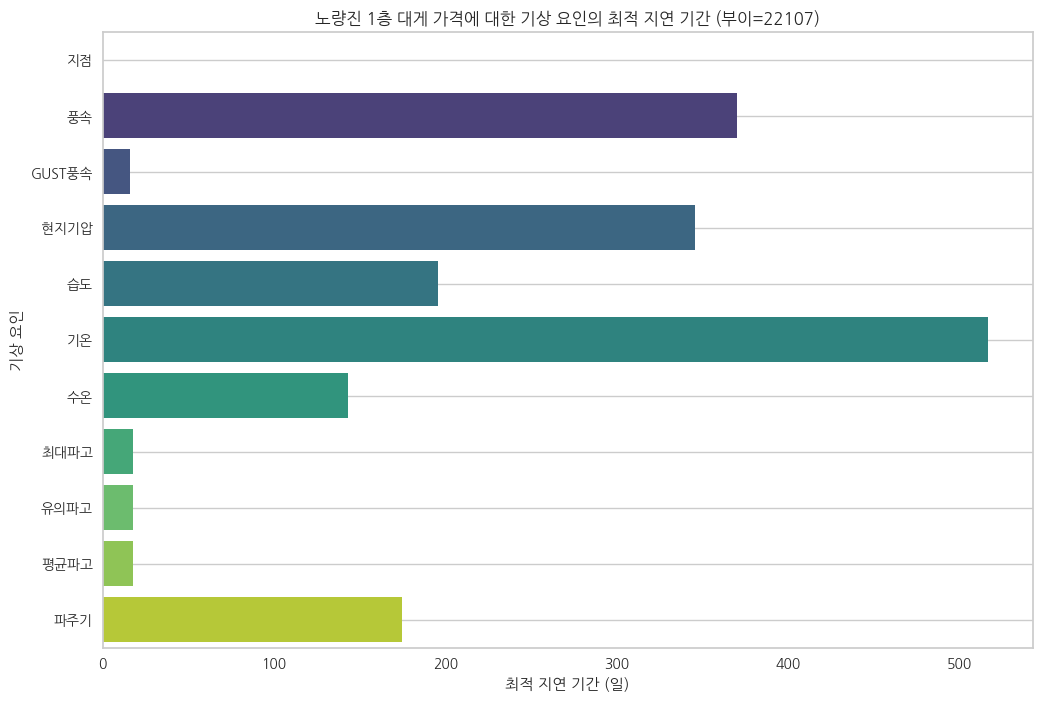


가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목=대게/ 시장=노량진 1층/ 부이=22302):
지점: 0일, 상관계수: -1.0000, 신뢰구간: nan ~ nan, 범위: nan
풍속: 377일, 상관계수: 0.2368, 신뢰구간: -0.1475 ~ 0.0153, 범위: 0.1629
GUST풍속: 377일, 상관계수: 0.3269, 신뢰구간: -0.2032 ~ -0.0627, 범위: 0.1405
현지기압: 337일, 상관계수: 0.6111, 신뢰구간: -0.4106 ~ -0.2837, 범위: 0.1269
습도: 536일, 상관계수: 0.6620, 신뢰구간: 0.3295 ~ 0.4272, 범위: 0.0977
기온: 512일, 상관계수: 0.7672, 신뢰구간: -0.0063 ~ 0.1022, 범위: 0.1085
수온: 493일, 상관계수: 0.7462, 신뢰구간: -0.2470 ~ -0.1439, 범위: 0.1030
최대파고: 376일, 상관계수: 0.3782, 신뢰구간: -0.2229 ~ -0.1138, 범위: 0.1091
유의파고: 376일, 상관계수: 0.4007, 신뢰구간: -0.2297 ~ -0.1149, 범위: 0.1148
평균파고: 376일, 상관계수: 0.4013, 신뢰구간: -0.2308 ~ -0.0995, 범위: 0.1313
파주기: 9일, 상관계수: 0.3337, 신뢰구간: -0.2118 ~ -0.1191, 범위: 0.0927


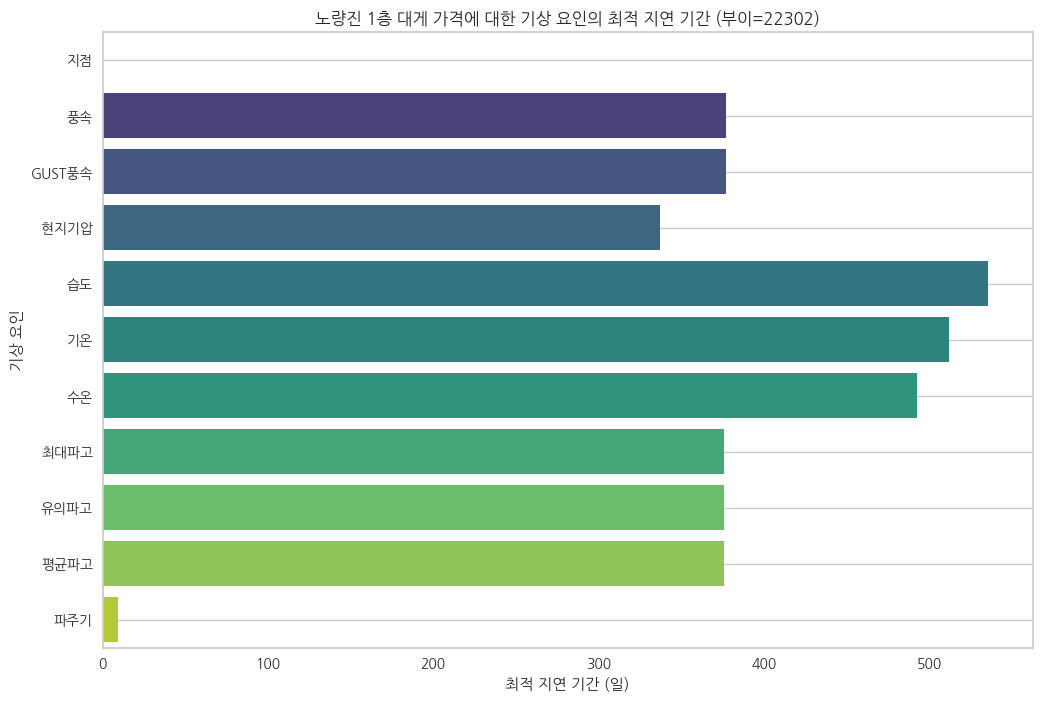

In [3]:
markets = ['가락시장', '노량진 1층']
items = ['대게']
buoys = [22107, 22302]  #22107:마라도, 22302:동해

for market in markets:
    for item in items:
        for buoy in buoys:
            lags(market, item, buoy)

In [4]:
# 가격 데이터 불러오기
df = pd.read_csv("../../data/prep/item_price_filled_pivot.csv")
df['priceDate'] = pd.to_datetime(df['priceDate'])
df = df[df['market'].isin(['노량진 1층','노량진 2층'])]
df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()
df.head()
# df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()

,priceDate,대게_avgPrice
0,2015-02-06,32000.0
1,2015-02-07,32000.0
2,2015-02-08,32000.0
3,2015-02-09,32000.0
4,2015-02-10,32000.0


In [5]:
# 가격 데이터 불러오기
df = pd.read_csv("../../data/prep/item_price_filled_pivot.csv")
df['priceDate'] = pd.to_datetime(df['priceDate'])
# df = df[df['market'].isin(['노량진 1층','노량진 2층'])] #노량진 시장으로 한정정
df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()
# df = df[df['item'] == "대게_avgPrice"]

#트렌드 지표
bigcrab = pd.read_csv("../../data/processed/그룹화_nst_대게_trend_2025-01-17.csv")
bigcrab['priceDate'] = pd.to_datetime(bigcrab['date'])# = bigcrab.drop(["date","name"], axis=1)

#경제지표
economy = pd.read_csv("../../data/prep/economy_filled.csv")
economy['priceDate'] = pd.to_datetime(economy['날짜'])
economy['USD/KRW'] = economy['USD/KRW'].shift(-2)
economy['KOSPI'] = economy['KOSPI'].shift(-4)
economy['Gold'] = economy['Gold'].shift(-150)
economy['WTI'] = economy['WTI'].shift(-101)

#환경지표
forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['priceDate'] = pd.to_datetime(forecast_df['일시'])
# 가거도 제거
forecast_df = forecast_df[~forecast_df['지점'].isin([22297, 22193])]
buoy_filtered = forecast_df[forecast_df['지점'] == 22107].drop(columns=['일시','풍속','GUST풍속','습도','기온','최대파고','유의파고','평균파고','파주기','지점'])

merged_df = pd.merge(df, bigcrab, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, economy, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, buoy_filtered, on='priceDate')
merged_df = merged_df.drop(["name","date","날짜"], axis=1)
merged_df['현지기압'] = merged_df['현지기압'].shift(-83)
# merged_df['수온'] = merged_df['수온'].shift(-143)
# merged_df['40대'] = merged_df['40대'].shift(-1)
# merged_df['20대'] = merged_df['20대'].shift(-1)
# merged_df['50대'] = merged_df['50대'].shift(-1)
# merged_df['30대'] = merged_df['30대'].shift(-1)
# merged_df['60대 이상'] = merged_df['60대 이상'].shift(-1)
merged_df = merged_df.drop(index=merged_df.index[-143:])
merged_df.head()

,priceDate,대게_avgPrice,20대,30대,40대,50대,60대 이상,KOSPI,USD/KRW,WTI,VIX,Gold,Silver,MOVE,현지기압,수온
0,2018-01-03,64685.714286,8.875036,17.436212,13.576893,9.880097,6.236522,2497.520020,1061.079956,67.389999,9.15,1294.800049,17.184999,47.599998,1020.270833,16.550000
1,2018-01-04,64392.857143,8.862564,17.328738,16.207602,13.251323,5.112482,2513.280029,1061.079956,67.389999,9.22,1294.800049,17.188999,47.380001,1018.645833,16.420833
2,2018-01-05,64535.714286,8.579787,17.294285,13.299009,12.524463,5.129686,2510.229980,1061.079956,66.220001,9.22,1293.099976,17.205000,46.070000,1019.845833,16.283333
3,2018-01-06,64618.571429,8.189937,13.286743,13.850701,9.705784,6.628747,2499.750000,1060.500000,66.519997,9.22,1297.500000,17.205000,46.070000,1022.195833,16.162500
4,2018-01-07,64618.571429,9.359353,13.742238,12.664761,11.098586,3.775999,2487.909912,1067.689941,68.470001,9.22,1297.500000,17.205000,46.070000,1020.762500,16.087500


In [6]:
# 예측할 대상과 특징 선택
features = ['20대', '30대','40대','50대','60대 이상', 'KOSPI', 'USD/KRW	', 'WTI', 'VIX', 'Gold', 'Silver', 'MOVE', '현지기압','수온']
target = '대게_avgPrice'

In [7]:
# AutoML 설정
regression_setup = setup(merged_df, target=target, session_id=42, normalize=True)

,Description,Value
0,Session id,42
1,Target,대게_avgPrice
2,Target type,Regression
3,Original data shape,"(2309, 16)"
4,Transformed data shape,"(2309, 18)"
5,Transformed train set shape,"(1616, 18)"
6,Transformed test set shape,"(693, 18)"
7,Numeric features,14
8,Date features,1
9,Rows with missing values,5.8%


In [8]:
# 최적 모델 찾기
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,781.0004,1244482.2448,1110.9705,0.9875,0.0201,0.0142,0.0540
catboost,CatBoost Regressor,1150.2779,2418867.7394,1550.0329,0.9755,0.0280,0.0209,0.6900
lightgbm,Light Gradient Boosting Machine,1302.3263,3582363.8594,1885.8387,0.9640,0.0338,0.0236,0.1460
xgboost,Extreme Gradient Boosting,1287.3578,3921085.0000,1953.7255,0.9609,0.0347,0.0233,0.2450
rf,Random Forest Regressor,1312.1971,3945630.4133,1971.7902,0.9608,0.0355,0.0239,0.1220
knn,K Neighbors Regressor,1248.3608,5155947.0250,2222.2271,0.9485,0.0393,0.0225,0.0140
gbr,Gradient Boosting Regressor,2068.0018,7349754.2210,2706.1650,0.9261,0.0488,0.0376,0.0750
dt,Decision Tree Regressor,1588.0529,9742074.5315,3049.2857,0.9042,0.0547,0.0290,0.0080
ada,AdaBoost Regressor,3579.1711,18108035.4164,4251.7755,0.8173,0.0782,0.0662,0.0300
ridge,Ridge Regression,6304.4433,61374379.6002,7808.9574,0.3855,0.1557,0.1163,0.1540


# 이하 최고 모델 저장

In [ ]:
# 가격 데이터 불러오기
df = pd.read_csv("../../data/prep/item_price_filled_pivot.csv")
df['priceDate'] = pd.to_datetime(df['priceDate'])
# df = df[df['market'].isin(['노량진 1층','노량진 2층'])] #노량진 시장으로 한정정
df = df.groupby('priceDate', as_index=False)['대게_avgPrice'].mean()
# df = df[df['item'] == "대게_avgPrice"]

#트렌드 지표
bigcrab = pd.read_csv("../../data/processed/그룹화_nst_대게_trend_2025-01-17.csv")
bigcrab['priceDate'] = pd.to_datetime(bigcrab['date'])# = bigcrab.drop(["date","name"], axis=1)

#경제지표
economy = pd.read_csv("../../data/prep/economy_filled.csv")
economy['priceDate'] = pd.to_datetime(economy['날짜'])
economy['USD/KRW'] = economy['USD/KRW'].shift(-2)
economy['KOSPI'] = economy['KOSPI'].shift(-4)
economy['Gold'] = economy['Gold'].shift(-150)
economy['WTI'] = economy['WTI'].shift(-101)

#환경지표
forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['priceDate'] = pd.to_datetime(forecast_df['일시'])
# 가거도 제거
forecast_df = forecast_df[~forecast_df['지점'].isin([22297, 22193])]
buoy_filtered = forecast_df[forecast_df['지점'] == 22107].drop(columns=['일시','풍속','GUST풍속','습도','기온','최대파고','유의파고','평균파고','파주기','지점'])

merged_df = pd.merge(df, bigcrab, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, economy, on='priceDate', how= 'inner')
merged_df = pd.merge(merged_df, buoy_filtered, on='priceDate')
merged_df = merged_df.drop(["name","date","날짜"], axis=1)
merged_df['현지기압'] = merged_df['현지기압'].shift(-83)
# merged_df['수온'] = merged_df['수온'].shift(-143)
# merged_df['40대'] = merged_df['40대'].shift(-1)
# merged_df['20대'] = merged_df['20대'].shift(-1)
# merged_df['50대'] = merged_df['50대'].shift(-1)
# merged_df['30대'] = merged_df['30대'].shift(-1)
# merged_df['60대 이상'] = merged_df['60대 이상'].shift(-1)
merged_df = merged_df.drop(index=merged_df.index[-143:])
merged_df.head()

,priceDate,대게_avgPrice,20대,30대,40대,50대,60대 이상,KOSPI,USD/KRW,WTI,VIX,Gold,Silver,MOVE,현지기압,수온
0,2018-01-03,64685.714286,8.875036,17.436212,13.576893,9.880097,6.236522,2497.520020,1061.079956,67.389999,9.15,1294.800049,17.184999,47.599998,1020.270833,16.550000
1,2018-01-04,64392.857143,8.862564,17.328738,16.207602,13.251323,5.112482,2513.280029,1061.079956,67.389999,9.22,1294.800049,17.188999,47.380001,1018.645833,16.420833
2,2018-01-05,64535.714286,8.579787,17.294285,13.299009,12.524463,5.129686,2510.229980,1061.079956,66.220001,9.22,1293.099976,17.205000,46.070000,1019.845833,16.283333
3,2018-01-06,64618.571429,8.189937,13.286743,13.850701,9.705784,6.628747,2499.750000,1060.500000,66.519997,9.22,1297.500000,17.205000,46.070000,1022.195833,16.162500
4,2018-01-07,64618.571429,9.359353,13.742238,12.664761,11.098586,3.775999,2487.909912,1067.689941,68.470001,9.22,1297.500000,17.205000,46.070000,1020.762500,16.087500


In [10]:
# 예측할 대상과 특징 선택
features = ['20대', '30대','40대','50대','60대 이상', 'KOSPI', 'USD/KRW	', 'WTI', 'VIX', 'Gold', 'Silver', 'MOVE', '현지기압','수온']
target = '대게_avgPrice'

In [11]:
# AutoML 설정
regression_setup = setup(merged_df, target=target, session_id=42, normalize=True)

,Description,Value
0,Session id,42
1,Target,대게_avgPrice
2,Target type,Regression
3,Original data shape,"(2309, 16)"
4,Transformed data shape,"(2309, 18)"
5,Transformed train set shape,"(1616, 18)"
6,Transformed test set shape,"(693, 18)"
7,Numeric features,14
8,Date features,1
9,Rows with missing values,5.8%


In [12]:
# 최적 모델 찾기
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,781.0004,1244482.2448,1110.9705,0.9875,0.0201,0.0142,0.0640
catboost,CatBoost Regressor,1150.2779,2418867.7394,1550.0329,0.9755,0.0280,0.0209,0.6730
lightgbm,Light Gradient Boosting Machine,1302.3263,3582363.8594,1885.8387,0.9640,0.0338,0.0236,0.1440
xgboost,Extreme Gradient Boosting,1287.3578,3921085.0000,1953.7255,0.9609,0.0347,0.0233,0.0900
rf,Random Forest Regressor,1312.1971,3945630.4133,1971.7902,0.9608,0.0355,0.0239,0.1340
knn,K Neighbors Regressor,1248.3608,5155947.0250,2222.2271,0.9485,0.0393,0.0225,0.0100
gbr,Gradient Boosting Regressor,2068.0018,7349754.2210,2706.1650,0.9261,0.0488,0.0376,0.0860
dt,Decision Tree Regressor,1588.0529,9742074.5315,3049.2857,0.9042,0.0547,0.0290,0.0080
ada,AdaBoost Regressor,3579.1711,18108035.4164,4251.7755,0.8173,0.0782,0.0662,0.0350
ridge,Ridge Regression,6304.4433,61374379.6002,7808.9574,0.3855,0.1557,0.1163,0.0060


In [13]:
# 사용 예시
target_column = '대게_avgPrice'
feature_columns = ['KOSPI', 'USD/KRW', 'WTI', 'VIX', 'Gold', 'Silver']

# 최적의 지연 기간 찾기
optimal_lags = find_optimal_lag(merged_df, target_column, feature_columns)

# 결과 출력
print("\n각 변수의 최적 지연 기간 및 상관계수:")
for feature, result in optimal_lags.items():
    print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}")

# 시각화
plt.figure(figsize=(10, 6))
lags = [res['최적 지연 기간'] for res in optimal_lags.values()]
plt.bar(feature_columns, lags)
plt.xlabel('Feature')
plt.ylabel('Optimal Lag (Days)')
plt.title('최적 지연 기간 비교')
plt.show()

NameError: name 'find_optimal_lag' is not defined

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['광어_score', '습도', '기온', '수온',
                                              '광어_대', '광어_중', '광어_소', 'USD/KRW',
                                              'WTI', 'Gold'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=42))]),
 'best_fish_price_model.pkl')

In [ ]:
df_merged = gen_merge_dataset(fill=False, item="광어")
best_model = run_automl_feature_importance(df_merged)
best_model.get_params()